# Activity: Explore confidence intervals

## Introduction

The Air Quality Index (AQI) is the Environmental Protection Agency's index for reporting air quality. A value close to 0 signals little to no public health concern, while higher values are associated with increased risk to public health. The United States is considering a new federal policy that would create a subsidy for renewable energy in states observing an average AQI of 10 or above. <br>

You've just started your new role as a data analyst in the Strategy division of Ripple Renewable Energy (RRE). **RRE operates in the following U.S. states: `California`, `Florida`, `Michigan`, `Ohio`, `Pennsylvania`, `Texas`.** You've been tasked with constructing an analysis which identifies which of these states are most likely to be affected, should the new federal policy be enacted.

Your manager has requested that you do the following for your analysis:
1. Provide a summary of the mean AQI for the states in which RRE operates.
2. Construct a boxplot visualization for AQI of these states using `seaborn`.
3. Evaluate which state(s) may be most affected by this policy, based on the data and your boxplot visualization.
4. Construct a confidence interval for the RRE state with the highest mean AQI.

## Step 1: Imports

### Import packages

Import `pandas` and `numpy`.

In [1]:
# Import packages
# Import the relevant Python libraries and modules needed in this lab.

### YOUR CODE HERE ###
# Import libraries and packages

# Import packages
from google.cloud import storage

import numpy as np
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import cm
from datetime import datetime
import glob
import os
from io import StringIO
from io import BytesIO
import json
import pickle
import six
import charset_normalizer
from wordcloud import WordCloud 
from typing import List

from scipy import stats
import statsmodels.api as sm

sns.set()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

import warnings
warnings.filterwarnings('ignore')

In [2]:
#storage_client =  storage.Client.from_service_account_json('../heidless-jupyter-0-d2008100d98c.json')
storage_client =  storage.Client()

BUCKET_NAME = 'heidless-jupyter-bucket-0'

bucket = storage_client.get_bucket(BUCKET_NAME)

AllCSV = []
my_prefix = 'air-quality/'
my_file = 'c4_epa_air_quality.csv'
full_file = my_prefix + my_file
#print(f'full_file: {full_file}')

file_names = list(bucket.list_blobs(prefix=my_prefix))
for file in file_names:
    if(file.name != my_prefix):
        if file.name == full_file:
            AllCSV.append(file.name)
#            print(file.name)
AllCSV


['air-quality/c4_epa_air_quality.csv']

In [3]:
# RUN THIS CELL TO IMPORT YOUR DATA.

### YOUR CODE HERE ###
#companies = pd.read_csv("Unicorn_Companies.csv")

# Display the first 10 rows of the data
all_dataframes = []

for csv in AllCSV:
    blob = bucket.get_blob(csv)
    if blob is not None and blob.exists(storage_client):
        bt = blob.download_as_string()
        s = str(bt, 'ISO-8859-1')
        s = StringIO(s)
        df = pd.read_csv(s, encoding='ISO-8859-1', low_memory=False)

        #df['country'] = csv[0:2] # adding column 'country' so that each dataset could be identified uniquely
        all_dataframes.append(df)
        print(csv)
    
#all_dataframes[0].head() # index 0 to 9 for [CA, DE, FR, GB, IN, JP, KR, MX, RU, US] datasets

aqi = all_dataframes[0]
aqi.head()


air-quality/c4_epa_air_quality.csv


,Unnamed: 0,date_local,state_name,county_name,city_name,local_site_name,parameter_name,units_of_measure,arithmetic_mean,aqi
0,0,2018-01-01,Arizona,Maricopa,Buckeye,BUCKEYE,Carbon monoxide,Parts per million,0.473684,7
1,1,2018-01-01,Ohio,Belmont,Shadyside,Shadyside,Carbon monoxide,Parts per million,0.263158,5
2,2,2018-01-01,Wyoming,Teton,Not in a city,Yellowstone National Park - Old Faithful Snow ...,Carbon monoxide,Parts per million,0.111111,2
3,3,2018-01-01,Pennsylvania,Philadelphia,Philadelphia,North East Waste (NEW),Carbon monoxide,Parts per million,0.300000,3
4,4,2018-01-01,Iowa,Polk,Des Moines,CARPENTER,Carbon monoxide,Parts per million,0.215789,3


In [ ]:
# Import relevant packages

### YOUR CODE HERE ###

### Load the dataset

The dataset provided gives national Air Quality Index (AQI) measurements by state over time.  `Pandas` is used to import the file `c4_epa_air_quality.csv` as a DataFrame named `aqi`. As shown in this cell, the dataset has been automatically loaded in for you. You do not need to download the .csv file, or provide more code, in order to access the dataset and proceed with this lab. Please continue with this activity by completing the following instructions.

*Note: For the purposes of your analysis, you can assume this data is randomly sampled from a larger population.*

# RUN THIS CELL TO IMPORT YOUR DATA

### YOUR CODE HERE ###
aqi = pd.read_csv('c4_epa_air_quality.csv')

## Step 2: Data exploration

### Explore your dataset

Before proceeding to your deliverables, spend some time exploring the `aqi` DataFrame. 

In [7]:
# Explore your DataFrame `aqi`.

### YOUR CODE HERE ###
print(aqi.describe(include='all'))

print(aqi['state_name'].value_counts())


        Unnamed: 0  date_local  state_name  county_name      city_name  \
count   260.000000         260         260          260            260   
unique         NaN           1          52          149            190   
top            NaN  2018-01-01  California  Los Angeles  Not in a city   
freq           NaN         260          66           14             21   
mean    129.500000         NaN         NaN          NaN            NaN   
std      75.199734         NaN         NaN          NaN            NaN   
min       0.000000         NaN         NaN          NaN            NaN   
25%      64.750000         NaN         NaN          NaN            NaN   
50%     129.500000         NaN         NaN          NaN            NaN   
75%     194.250000         NaN         NaN          NaN            NaN   
max     259.000000         NaN         NaN          NaN            NaN   

       local_site_name   parameter_name   units_of_measure  arithmetic_mean  \
count              257          

**Question:** What time range does this data cover?

[Write your response here. Double-click (or enter) to edit.]


**Question:** What are the minimum and maximum AQI values observed in the dataset?

[Write your response here. Double-click (or enter) to edit.]

**Question:** Are all states equally represented in the dataset?

[Write your response here. Double-click (or enter) to edit.]

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about descriptive statisics](https://www.coursera.org/learn/the-power-of-statistics/lecture/jVRS4/measures-of-central-tendency).
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Use `pandas` or `numpy` to explore the `aqi` DataFrame.
</details>

<details>
  <summary><h4><strong>Hint 3</strong></h4></summary>

Use any of the following functions:
- `pandas`: `describe()`,`value_counts()`,`shape()`
- `numpy`: `unique()`,`mean()`
    
</details>

## Step 3: Statistical tests

### Summarize the mean AQI for RRE states

Start with your first deliverable. Summarize the mean AQI for the states in which RRE operates (California, Florida, Michigan, Ohio, Pennsylvania, and Texas).

In [11]:
# Summarize the mean AQI for RRE states.

### YOUR CODE HERE ###

# Create a list of RRE states.
rre_states = ['California', 'Florida', 'Michigan', 'Ohio', 'Pennsylvania', 'Texas']

# Subset `aqi` to only consider these states.
aqi_rre = aqi[aqi['state_name'].isin(rre_states)]
aqi_rre.head(5)

# Find the mean aqi for each of the RRE states.
aqi_rre.groupby('state_name').agg({'aqi':'mean', 'state_name':'count'})


,aqi,state_name
state_name,,
California,12.121212,66
Florida,5.500000,12
Michigan,8.111111,9
Ohio,3.333333,12
Pennsylvania,2.900000,10
Texas,2.700000,10


<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Subset your DataFrame to only include those states in which RRE operates. 
    
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Define a list consisting of the states in which RRE operates and use that list to subset your DataFrame. 
    
</details>

<details>
  <summary><h4><strong>Hint 3</strong></h4></summary>

Use `pandas` `isin.()` to subset your DataFrame by the list of RRE states.
    
</details>

### Construct a boxplot visualization for the AQI of these states

Seaborn is a simple visualization library, commonly imported as `sns`. Import `seaborn`. Then utilize a boxplot visualization from this library to compare the distributions of AQI scores by state.

In [ ]:
# Import seaborn as sns.

### YOUR CODE HERE ###

### Create an in-line visualization showing the distribution of `aqi` by `state_name`

Now, create an in-line visualization showing the distribution of `aqi` by `state_name`.

[None, None, None, None, None, None]

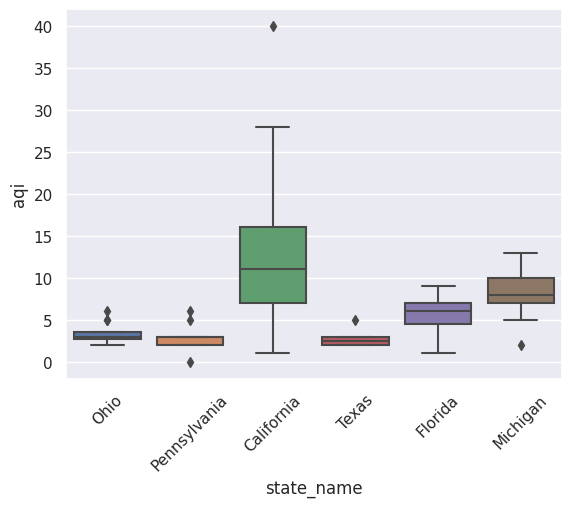

In [19]:
### YOUR CODE HERE ###

g = sns.boxplot(x=aqi_rre["state_name"],y=aqi_rre["aqi"])
plt.setp(g.get_xticklabels(), rotation=45)

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Use the boxplot visual for this purpose.
    
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Reference [Seaborn's boxplot visualization documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html). 
    
</details>

<details>
  <summary><h4><strong>Hint 3</strong></h4></summary>

Assign `state_name` to the x argument and `aqi` to the y.
    
</details>

**Question:** Based on the data and your visualizations, which state(s) do you suspect will be most affected by this policy?

[Write your response here. Double-click (or enter) to edit.]

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Consider the mean AQI for the RRE states, as well as the distribution in the boxplots relative to the policy limit (10).
    
</details>

### Construct a confidence interval for the RRE state with the highest mean AQI

Recall the 4-step process in constructing a confidence interval:

1.   Identify a sample statistic.
2.   Choose a confidence level.
3.   Find the margin of error. 
4.   Calculate the interval.

### Construct your sample statistic

To contruct your sample statistic, find the mean AQI for your state.

In [26]:
# Find the mean aqi for your state.

### YOUR CODE HERE ###
aqi_ca = aqi[aqi['state_name'] == 'California']
sample_mean = aqi_ca['aqi'].mean()
sample_mean

12.121212121212121

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Reference what you've previously learned to recall what a [sample statistic](https://www.coursera.org/learn/the-power-of-statistics/supplement/cdOx7/construct-a-confidence-interval-for-a-small-sample-size) is.
    
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Calculate the mean for your highest AQI state to arrive at your sample statistic.
    
</details>

<details>
 <summary><h4><strong>Hint 3</strong></h4></summary>

Call the `mean()` function within `pandas` on your DataFrame.
    
</details>

### Choose your confidence level

Choose your confidence level for your analysis. The most typical confidence level chosen is 95%; however, you can choose 90% or 99% if you want decrease or increase (respectively) your level of confidence about your result.

In [27]:
# Input your confidence level here:

### YOUR CODE HERE ###

confidence_level = 0.95
confidence_level

0.95

### Find your margin of error (ME)

Recall **margin of error = z * standard error**, where z is the appropriate z-value for the given confidence level. To calculate your margin of error:

- Find your z-value. 
- Find the approximate z for common confidence levels.
- Calculate your **standard error** estimate. 

| Confidence Level | Z Score |
| --- | --- |
| 90% | 1.65 |
| 95% | 1.96 |
| 99% | 2.58 |


In [31]:
# Calculate your margin of error.

### YOUR CODE HERE ###

# Begin by identifying the z associated with your chosen confidence level.
z_value = 1.96

standard_error = aqi_ca['aqi'].std() / np.sqrt(aqi_ca.shape[0])
print("standard error:")
print(standard_error)
# Lastly, use the preceding result to calculate your margin of error.

margin_of_error = standard_error * z_value
print("margin of error:")
print(margin_of_error)

standard error:
0.8987209641127412
margin of error:
1.7614930896609726


### Calculate your interval

Calculate both a lower and upper limit surrounding your sample mean to create your interval.

In [32]:
# Calculate your confidence interval (upper and lower limits).

### YOUR CODE HERE ###
upper_ci_limit = sample_mean + margin_of_error
lower_ci_limit = sample_mean - margin_of_error
(lower_ci_limit, upper_ci_limit)

(10.359719031551148, 13.882705210873095)

<details>
  <summary><h4><strong>Hint 1</strong></h4></summary>

Refer to [the content about constructing a confidence interval](https://www.coursera.org/learn/the-power-of-statistics/lecture/3jbsX/construct-a-confidence-interval-for-a-proportion).
    
</details>

<details>
  <summary><h4><strong>Hint 2</strong></h4></summary>

Identify the sample mean from your prior work. Then use the margin of error to construct your upper and lower limits.  
    
</details>

<details>
  <summary><h4><strong>Hint 3</strong></h4></summary>

Subtract the margin of error from the sample mean to construct your lower limit, and add the margin of error to your sample mean to construct your upper limit.
    
</details>

### Alternative: Construct the interval using `scipy.stats.norm.interval()`

`scipy` presents a simpler solution to developing a confidence interval. To use this, first import the `stats` module from `scipy`.

In [33]:
# Import stats from scipy.

### YOUR CODE HERE ###

## Step 4: Results and evaluation

### Recalculate your confidence interval

Provide your chosen `confidence_level`, `sample_mean`, and `standard_error` to `stats.norm.interval()` and recalculate your confidence interval.

In [34]:
### YOUR CODE HERE ###
stats.norm.interval(confidence=0.95, loc=sample_mean, scale=standard_error)

(10.359751399400034, 13.882672843024208)

# Considerations

**What are some key takeaways that you learned from this lab?**

[Write your response here. Double-click (or enter) to edit.]

**What findings would you share with others?**

[Write your response here. Double-click (or enter) to edit.]

**What would you convey to external stakeholders?**

[Write your response here. Double-click (or enter) to edit.]

**References**

[seaborn.boxplot — seaborn 0.12.1 documentation](https://seaborn.pydata.org/generated/seaborn.boxplot.html). (n.d.). 

**Congratulations!** You've completed this lab. However, you may not notice a green check mark next to this item on Coursera's platform. Please continue your progress regardless of the check mark. Just click on the "save" icon at the top of this notebook to ensure your work has been logged.